<a href="https://colab.research.google.com/github/yoonmisu/AI_project/blob/main/AIproject_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_dir = "/content/drive/MyDrive/Jelly_Detergent_dataset"
jelly_dir = os.path.join(base_dir, "Jelly")
detergent_dir = os.path.join(base_dir, "Detergent")

print("Jelly 이미지 개수:", len(os.listdir(jelly_dir)))
print("Detergent 이미지 개수:", len(os.listdir(detergent_dir)))

Jelly 이미지 개수: 148
Detergent 이미지 개수: 192


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 전처리: 크기 조정 + 정규화
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 271 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [ ]:
!rm -rf /content/drive/MyDrive/Jelly_Detergent_dataset/train

In [ ]:
!rm -rf /content/drive/MyDrive/Jelly_Detergent_dataset/val

In [ ]:
print(train_gen.class_indices)

{'Detergent': 0, 'Jelly': 1}


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. 데이터 경로
base_dir = "/content/drive/MyDrive/dataset_gray/train"
img_size = (150, 150)
batch_size = 16

# 2. 데이터 증강 및 전처리
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode='nearest'
)

# 수정 전: 1채널(흑백)로 로드하려고 했음
# color_mode='grayscale'
# 수정 후: 3채널(RGB)로 로드하도록 변경 (흑백 이미지는 3채널에 모두 같은 값으로 복제되어 로드됨)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

val_data = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    color_mode='rgb'
)

# 모델은 3채널 입력과 가중치를 사용하도록
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3) # 3채널 입력으로 변경
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 4. EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 5. 1단계 학습
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)

# 6. 2단계 Fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)

print("최종 학습 완료")


Found 271 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


/tmp/ipython-input-1050865786.py:55: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 997ms/step - accuracy: 0.5745 - loss: 1.0416 - val_accuracy: 0.7015 - val_loss: 0.6064
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 748ms/step - accuracy: 0.4993 - loss: 0.9939 - val_accuracy: 0.7015 - val_loss: 0.5885
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 725ms/step - accuracy: 0.6373 - loss: 0.6611 - val_accuracy: 0.7910 - val_loss: 0.4785
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 757ms/step - accuracy: 0.7096 - loss: 0.7282 - val_accuracy: 0.8657 - val_loss: 0.3894
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - accuracy: 0.7475 - loss: 0.5696 - val_accuracy: 0.8358 - val_loss: 0.3848
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 773ms/step - accuracy: 0.7802 - loss: 0.5768 - val_accuracy: 0.8358 - val_loss: 0.3644
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 764ms/step - accuracy: 0.7885 - loss: 0.5069 - val_accuracy: 0.8806 - val_loss: 0.3015
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 672ms/step - accuracy: 0.8410 - loss: 0.3713 - val_accu

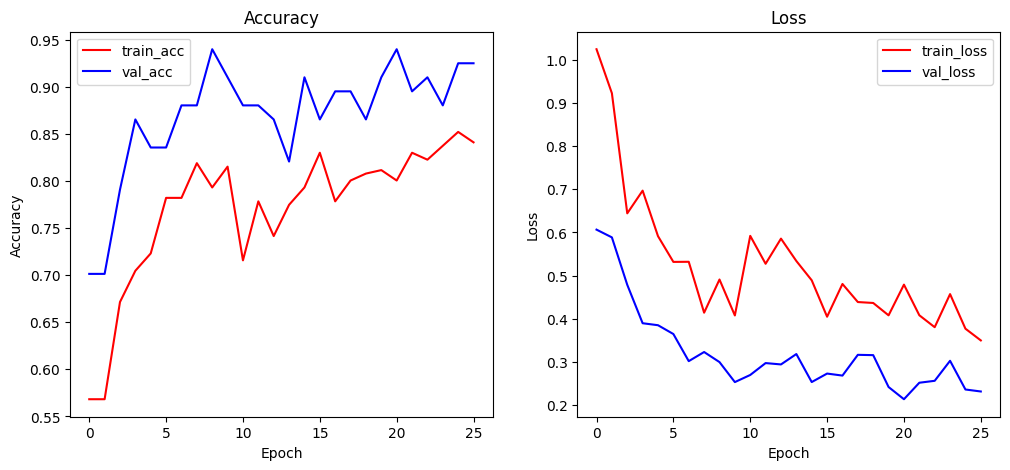

In [ ]:
# 학습 그래프 시각화
def plot_training_history(h1, h2):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'] + h2.history['accuracy'], label='train_acc', color='red')
    plt.plot(h1.history['val_accuracy'] + h2.history['val_accuracy'], label='val_acc', color='blue')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'] + h2.history['loss'], label='train_loss', color='red')
    plt.plot(h1.history['val_loss'] + h2.history['val_loss'], label='val_loss', color='blue')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history1, history2)

In [ ]:
print(train_data.class_indices)
print(train_data.samples, "training samples")
print(val_data.samples, "validation samples")

{'Detergent': 0, 'Jelly': 1}
271 training samples
67 validation samples


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print("📂 업로드 완료:", img_path)

Saving jelee.jpg to jelee (1).jpg
📂 업로드 완료: jelee (1).jpg


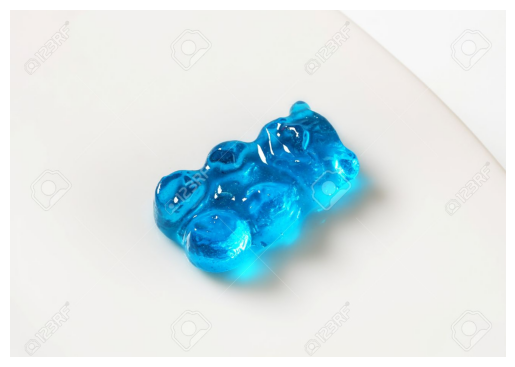

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
예측 결과: Jelly
확률(0=세제, 1=젤리): 0.6168087


/tmp/ipython-input-1558877897.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("예측 결과:", class_names[int(pred[0] > 0.5)])


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 업로드한 이미지 컬러 확인
img_color = Image.open(img_path)
plt.imshow(img_color)
plt.axis("off")
plt.show()

# 흑백 변환 후 모델 입력
img_gray = img_color.convert("L").resize((150,150))
img_array = np.array(img_gray)/255.0
img_array = np.expand_dims(img_array, axis=-1)

# 1채널을 3채널로 복제 (MobileNetV2에 맞춤)
img_array_3ch = np.repeat(img_array, 3, axis=-1)

# 배치 차원 추가
img_array_final = np.expand_dims(img_array_3ch, axis=0)

# 예측
pred = model.predict(img_array_final)
class_names = ['Detergent', 'Jelly']
print("예측 결과:", class_names[int(pred[0] > 0.5)])
print("확률(0=세제, 1=젤리):", pred[0][0])


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print("업로드 완료:", img_path)

Saving detergentttt.jpg to detergentttt (1).jpg
업로드 완료: detergentttt (1).jpg


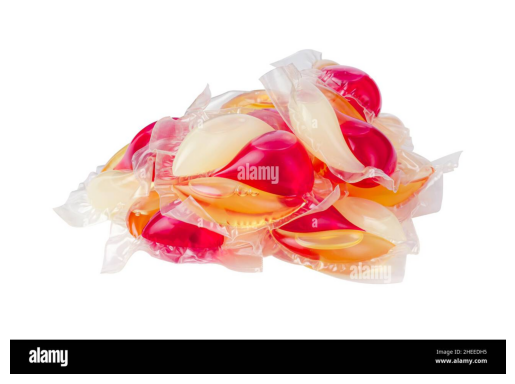

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
예측 결과: Detergent
확률(0=세제, 1=젤리): 0.24144705


/tmp/ipython-input-292253519.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("예측 결과:", class_names[int(pred[0] > 0.5)])


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 업로드한 이미지 컬러 확인
img_color = Image.open(img_path)
plt.imshow(img_color)
plt.axis("off")
plt.show()

# 흑백 변환 후 모델 입력
img_gray = img_color.convert("L").resize((150,150))
img_array = np.array(img_gray)/255.0
img_array = np.expand_dims(img_array, axis=-1)

# 1채널을 3채널로 복제 (MobileNetV2에 맞춤)
img_array_3ch = np.repeat(img_array, 3, axis=-1)

# 배치 차원 추가
img_array_final = np.expand_dims(img_array_3ch, axis=0)

# 예측
pred = model.predict(img_array_final)
class_names = ['Detergent', 'Jelly']
print("예측 결과:", class_names[int(pred[0] > 0.5)])
print("확률(0=세제, 1=젤리):", pred[0][0])

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print("📂 업로드 완료:", img_path)

Saving purple.jpeg to purple (1).jpeg
📂 업로드 완료: purple (1).jpeg


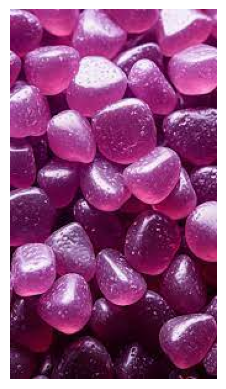

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
예측 결과: Jelly
확률(0=세제, 1=젤리): 0.99778455


/tmp/ipython-input-292253519.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("예측 결과:", class_names[int(pred[0] > 0.5)])


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 업로드한 이미지 컬러 확인
img_color = Image.open(img_path)
plt.imshow(img_color)
plt.axis("off")
plt.show()

# 흑백 변환 후 모델 입력
img_gray = img_color.convert("L").resize((150,150))
img_array = np.array(img_gray)/255.0
img_array = np.expand_dims(img_array, axis=-1)

# 1채널을 3채널로 복제 (MobileNetV2에 맞춤)
img_array_3ch = np.repeat(img_array, 3, axis=-1)

# 배치 차원 추가
img_array_final = np.expand_dims(img_array_3ch, axis=0)

# 예측
pred = model.predict(img_array_final)
class_names = ['Detergent', 'Jelly']
print("예측 결과:", class_names[int(pred[0] > 0.5)])
print("확률(0=세제, 1=젤리):", pred[0][0])

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print("업로드 완료:", img_path)

Saving yellow.jpg to yellow (1).jpg
업로드 완료: yellow (1).jpg


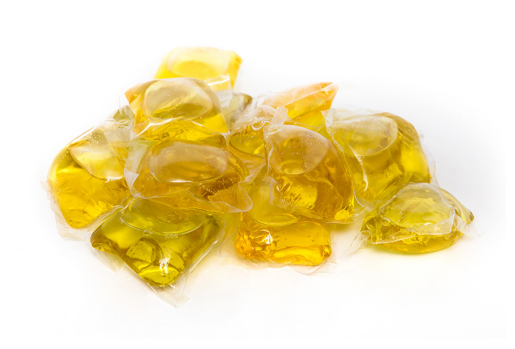

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
예측 결과: Detergent
확률(0=세제, 1=젤리): 0.21143721


/tmp/ipython-input-1558877897.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("예측 결과:", class_names[int(pred[0] > 0.5)])


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 업로드한 이미지 컬러 확인
img_color = Image.open(img_path)
plt.imshow(img_color)
plt.axis("off")
plt.show()

# 흑백 변환 후 모델 입력
img_gray = img_color.convert("L").resize((150,150))
img_array = np.array(img_gray)/255.0
img_array = np.expand_dims(img_array, axis=-1)

# 1채널을 3채널로 복제 (MobileNetV2에 맞춤)
img_array_3ch = np.repeat(img_array, 3, axis=-1)

# 배치 차원 추가
img_array_final = np.expand_dims(img_array_3ch, axis=0)

# 예측
pred = model.predict(img_array_final)
class_names = ['Detergent', 'Jelly']
print("예측 결과:", class_names[int(pred[0] > 0.5)])
print("확률(0=세제, 1=젤리):", pred[0][0])


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print("📂 업로드 완료:", img_path)

Saving jellyyyy.jpg to jellyyyy.jpg
📂 업로드 완료: jellyyyy.jpg


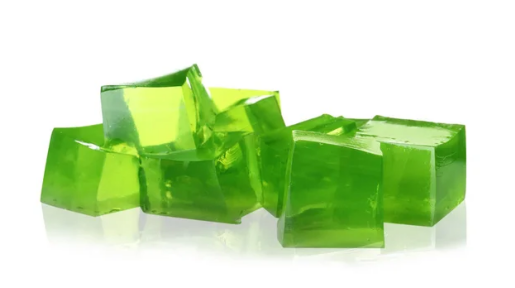

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
✅ 예측 결과: Jelly
📊 확률(0=세제, 1=젤리): 0.6282124


/tmp/ipython-input-635377894.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("✅ 예측 결과:", class_names[int(pred[0] > 0.5)])


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ① 업로드한 이미지 컬러 확인
img_color = Image.open(img_path)
plt.imshow(img_color)
plt.axis("off")
plt.show()

# ② 흑백 변환 후 모델 입력
img_gray = img_color.convert("L").resize((150,150))
img_array = np.array(img_gray)/255.0
img_array = np.expand_dims(img_array, axis=-1)  # 현재 모양: (150, 150, 1)

# ★★★ 중요 수정: 1채널을 3채널로 복제 (MobileNetV2에 맞춤) ★★★
img_array_3ch = np.repeat(img_array, 3, axis=-1) # 모양: (150, 150, 3)

# 배치 차원 추가
img_array_final = np.expand_dims(img_array_3ch, axis=0) # 모양: (1, 150, 150, 3)

# ③ 예측
# 수정된 3채널 텐서 사용
pred = model.predict(img_array_final)
class_names = ['Detergent', 'Jelly']
print("✅ 예측 결과:", class_names[int(pred[0] > 0.5)])
print("📊 확률(0=세제, 1=젤리):", pred[0][0])